# Spam Email Classification: Using LSTM


## Data Preprocessing

To prepare the dataset for spam email classification, the following libraries and tools are imported:  

- NumPy
- Pandas
- NLTK (Natural Language Toolkit
- Regular Expressions (`re`)

In [30]:
# Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Visualization

For exploring and visualizing the dataset, the following libraries and tools are utilized:  

- **Matplotlib**: For creating static, animated, and interactive visualizations.  
- **Collections (Counter)**: For counting occurrences of elements in the dataset, such as word frequencies.  
- **WordCloud**: For generating word cloud representations to visualize common terms in the dataset.

In [31]:
# Visualization
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Bidirectional
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

## Load the Dataset

The dataset is loaded into a DataFrame for further analysis. In this dataset:

- **`1`** indicates that the email is classified as **spam**.
- **`0`** denotes that the email is **legitimate (ham)**.

A preview of the first few records provides an overview of the data structure and content.

In [32]:
# Load the dataset
df = pd.read_csv("emails.csv")
df.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Check for Missing Values

To ensure the dataset is complete and ready for analysis, we check for any missing values. This step helps identify if there are any gaps in the data that need to be handled before model training.

In [33]:
print(df.isnull().sum())

text    0
spam    0
dtype: int64


## Check the Shape of the Data

The shape of the dataset is examined to understand its structure, including the number of records (rows) and features (columns). This provides an overview of the dataset's size before processing.

In [34]:
df.shape

(5728, 2)

## Convert Text to Lowercase

To standardize the text data, all email content is converted to lowercase. This step helps ensure that words with different cases (e.g., "Spam" and "spam") are treated as the same during analysis.


In [35]:
df['text'] = df['text'].str.lower()

## Remove Numbers and Special Characters

Special characters, symbols, and numbers are often irrelevant for distinguishing between spam and legitimate emails. Therefore, these elements are removed to clean the text data and focus on meaningful words.

In [36]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_special_characters)

## Remove English Stop-Words

Common words such as "the", "a", and "of" (known as stop-words) are removed from the text since they do not add significant meaning for spam classification. By eliminating these words, we can focus on the more informative content of the emails.

In [37]:
# Define stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

# Tokenize the text
df['text'] = df['text'].apply(word_tokenize)

# Remove stop words
df['text'] = df['text'].apply(remove_stop_words)

# Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)

## Removal of Hyperlinks

Hyperlinks (URLs) present in emails are removed, as they generally do not contribute useful information for spam classification. This step helps clean the text and focus on the actual content of the emails.

In [38]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

## Exploratory Data Analysis

To gain insights into the dataset, we perform an initial exploration by reviewing a few examples of spam emails. This helps us understand the content and structure of spam messages, providing context for the classification task.

In [39]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['spam'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
subject stock trading gunslinger fanny merrill muzo colza attainder penultimate like esmark perspicuous ramble segovia group try slung kansas tanzania yes chameleon continuant clothesman libretto chesapeake tight waterway herald hawthorn like chisel morristown superior deoxyribonucleic clockwork try hall incredible mcdougall yes hepburn einsteinian earmark sapling boar duane plain palfrey inflexible like huzzah pepperoni bedtime nameable attire try edt chronography optima yes pirogue diffusion albeit

Email #2
subject unbelievable new homes made easy im wanting show homeowner pre approved 454 169 home loan 3 72 fixed rate offer extended unconditionally credit way factor take advantage limited time opportunity ask visit website complete 1 minute post approval form look foward hearing dorcas pittman



## Exploring Legitimate Email Examples

To further understand the characteristics of legitimate emails, we review a few examples from the dataset. This helps distinguish the differences between spam and legitimate content.


In [40]:
for i in range (1,3):
    print("Email #"+str(i))
    legitimate_email = df[df['spam'] == 0]['text'].iloc[i]
    print(legitimate_email+"\n")

Email #1
subject sacramento weather station fyi forwarded mike roberts hou ect 09 20 2000 09 06 scott tholan enron 09 19 2000 07 57 pm mark tawney hou ect ect gary taylor hou ect ect mike roberts hou ect ect cc chris clark na enron enron subject sacramento weather station hey guys talking contractor build us weather station hopefully quickly placement sacramento california variety legal contractor operational reasons need confirm following requirements soon possible proceed need rainfall snowfall temperature measurement one high accuracy commercially available weather station b need daily feed data enron weather desk mean one data dump set time per day alternatively need check data real time perhaps varying multiple times day c installing station near sacramento california need know exactly areas near sacramento suitable site weather station name town mentioned mark interest time recommend weather expert accompany landman select site allow landman quickly lease install station desire i

## Spam vs. Legitimate Email Distribution

A pie chart is used to visualize the distribution of spam and legitimate emails in the dataset.

The chart reveals that approximately **52.6%** of the emails are classified as spam, while **47.4%** are legitimate. This nearly balanced distribution is beneficial for training machine learning models, as it reduces the risk of bias towards either class, ensuring a more accurate and fair model.

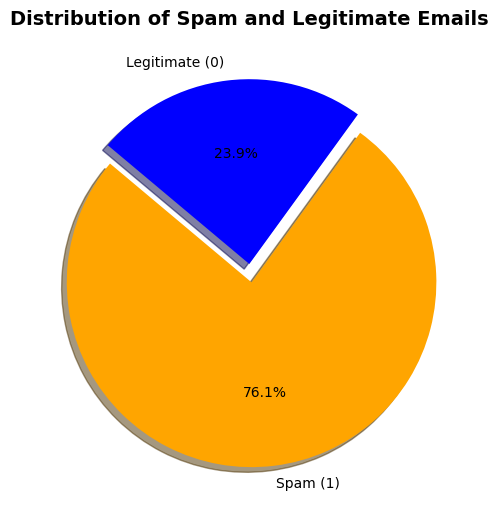

In [41]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Count the number of spam and legitimate emails
email_counts = df['spam'].value_counts()

# Define labels and colors for the pie chart
labels = ['Spam (1)', 'Legitimate (0)']
colors = ['orange', 'blue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    email_counts,
    labels=labels,
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=140,     # Rotate the chart for better aesthetics
    colors=colors,      # Custom colors for each category
    explode=(0.1, 0),   # Slightly "explode" the spam category for emphasis
    shadow=True         # Add shadow for a 3D effect
)

# Add a title with better formatting
plt.title('Distribution of Spam and Legitimate Emails', fontsize=14, fontweight='bold')

# Display the chart
plt.show()

## Word Frequency Analysis

A bar chart is created to compare the most frequent words found in both spam and legitimate emails. This analysis helps identify key terms that are commonly associated with each type of email.

By separating the spam and legitimate emails and counting the word frequencies, we can observe differences in the language used. This can be a valuable feature for training classification models, as certain words or phrases may be indicative of spam or legitimate content.

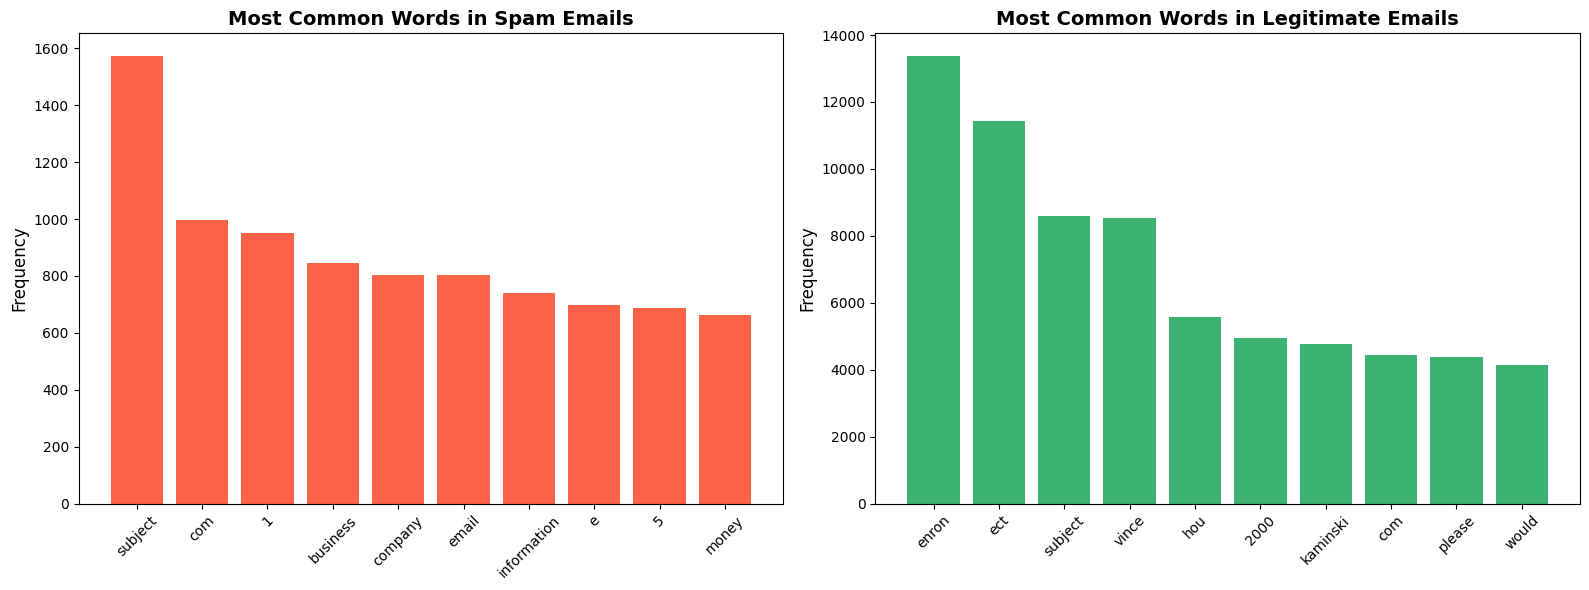

In [42]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Separate the spam and legitimate emails
spam_emails = df.loc[df['spam'] == 1, 'text']
legit_emails = df.loc[df['spam'] == 0, 'text']

# Define a function to count word frequencies
def count_word_frequencies(email_series):
    word_counter = Counter()
    email_series.str.split().apply(word_counter.update)
    return word_counter

# Count word frequencies for spam and legitimate emails
spam_words = count_word_frequencies(spam_emails)
legit_words = count_word_frequencies(legit_emails)

# Get the 10 most common words for each category
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

# Convert to DataFrames for visualization
spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

# Set up the figure for plotting
plt.figure(figsize=(16, 6))

# Plot the most common words in spam emails
plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='tomato')
plt.title('Most Common Words in Spam Emails', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Frequency', fontsize=12)

# Plot the most common words in legitimate emails
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='mediumseagreen')
plt.title('Most Common Words in Legitimate Emails', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout for better visual appeal
plt.tight_layout()

# Display the plots
plt.show()

This comparison highlights the key differences in language use between spam and legitimate emails, providing insights into the vocabulary patterns that can help in distinguishing between the two types of messages.

## Word Cloud for Spam Emails

A word cloud is generated to visualize the most common words found in spam emails. This graphic representation highlights the frequency of words, with larger words appearing more often in the dataset. Word clouds provide an intuitive way to identify recurring themes or terms in spam emails.

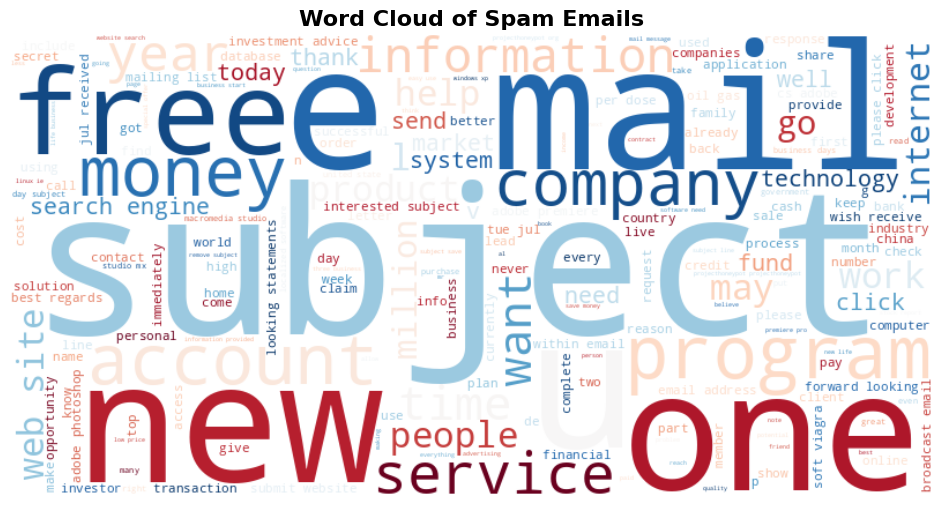

In [43]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud image for spam words
spam_wordcloud = WordCloud(
    width=800,  # Width of the image
    height=400,  # Height of the image
    background_color='white',  # Background color for better visibility
    colormap='RdBu',  # Color theme to match the spam context
    max_words=200,  # Limit the number of words to show in the cloud
    contour_color='black',  # Optional: Outline color for the word cloud
    contour_width=1  # Optional: Outline width for a polished look
).generate(' '.join(spam_emails))  # Join all spam emails into a single string

# Display the word cloud image
plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization
plt.imshow(spam_wordcloud, interpolation='bilinear')  # Use bilinear interpolation for smooth display
plt.axis('off')  # Turn off axes for a clean look
plt.title('Word Cloud of Spam Emails', fontsize=16, fontweight='bold')  # Add a descriptive title
plt.show()

## N-gram Analysis

N-gram analysis is conducted to explore common sequences of two (bigrams) or more words in both spam and legitimate emails. By examining these sequences, we can better understand the frequent phrases and language patterns used in each type of email.

In this analysis, we focus on extracting and counting bigrams (two-word sequences) from the email text, providing insight into how certain word combinations are more common in spam emails compared to legitimate ones.


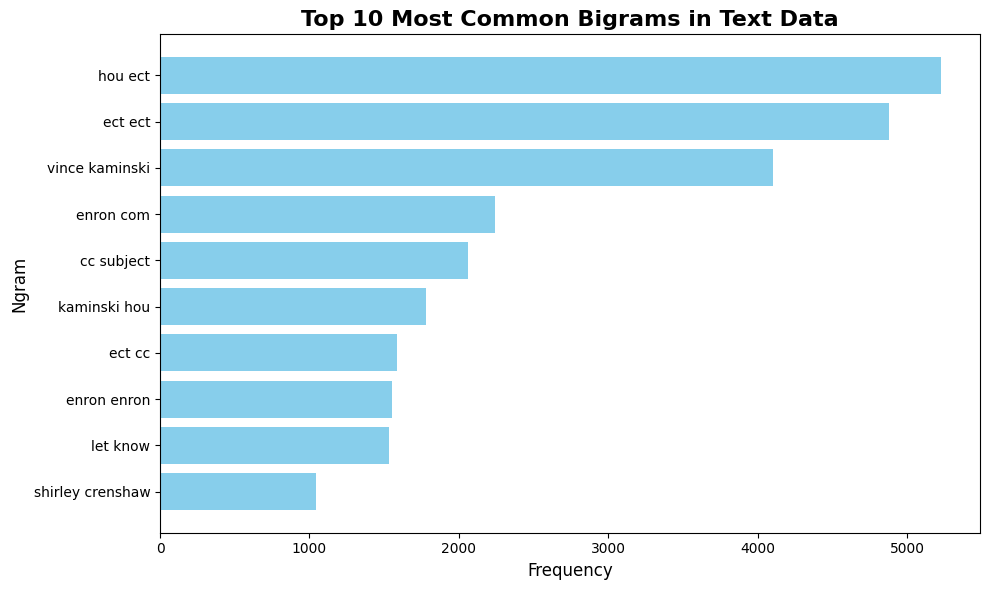

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=10, title='Top Ngrams', color='skyblue'):
    """
    Generate and visualize the top n-grams in a given text corpus.

    Args:
        corpus (list): List of text data to analyze.
        ngram_range (tuple): The range of n-grams to consider, e.g., (2, 2) for bigrams.
        top_n (int): The number of top n-grams to display.
        title (str): The title of the plot.
        color (str): The color of the bars in the plot.
    """
    # Create a CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_matrix = vectorizer.fit_transform(corpus)

    # Sum the occurrences of each n-gram
    ngram_counts = ngram_matrix.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()

    # Create a DataFrame of n-grams and their frequencies
    ngrams_df = pd.DataFrame({'Ngram': ngram_features, 'Frequency': ngram_counts})
    ngrams_df = ngrams_df.sort_values(by='Frequency', ascending=False).head(top_n)

    # Plot the top n-grams
    plt.figure(figsize=(10, 6))
    plt.barh(ngrams_df['Ngram'], ngrams_df['Frequency'], color=color)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Ngram', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()  # Display the highest frequency at the top
    plt.tight_layout()
    plt.show()

# Example usage: Analyzing bigrams in the dataset
plot_top_ngrams(
    df['text'],
    ngram_range=(2, 2),
    top_n=10,
    title='Top 10 Most Common Bigrams in Text Data',
    color='skyblue'
)

## Feature Engineering: Data Splitting

In the feature engineering phase, the dataset is divided into features (X) and target labels (y). The features represent the email text, while the target indicates whether the email is spam (1) or legitimate (0).

In [45]:
# Split the data into features and target
X = df['text']
y = df['spam']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Tokenization

Tokenization is the process of breaking down text into smaller, manageable units called tokens. These tokens serve as the input features for machine learning algorithms.

In this project, the `Tokenizer` from Keras is used to convert the email text into sequences of tokens. By setting a maximum number of features (e.g., 5000), we limit the vocabulary to only the most frequently occurring words, helping manage the size and relevance of the dataset.

After fitting the tokenizer on the training data, the email text is converted into numerical sequences that can be used by machine learning models.

In [46]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [47]:
df.head()

,text,spam
0,subject naturally irresistible corporate ident...,1
1,subject stock trading gunslinger fanny merrill...,1
2,subject unbelievable new homes made easy im wa...,1
3,subject 4 color printing special request addit...,1
4,subject money get software cds software compat...,1


## Sequence Padding for Consistent Input Lengths

Padding is a technique used to ensure that all sequences of tokens have the same length. Since machine learning models process input in batches, sequences of varying lengths can cause information loss or inconsistencies during training. By padding the sequences to a uniform size, we ensure that each input is of equal length, which improves the efficiency and effectiveness of batch processing.


In [48]:
# Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

max_length = 500 # Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Average Length: 1026.4802723463688


## Label Encoding for Target Variable


In [49]:
# Import the LabelEncoder class from scikit-learn to encode categorical labels into numerical values.
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the training data (y_train) and transform the labels into numerical values.
# The labels in y_train (e.g., 'spam' and 'ham') will be converted to integers (e.g., 1 and 0).
y_train_encoded = label_encoder.fit_transform(y_train)

# Use the fitted LabelEncoder to transform the test data labels (y_test).
# It ensures that the same encoding scheme applied to y_train is applied to y_test, ensuring consistency.
y_test_encoded = label_encoder.transform(y_test)

In [50]:
import pickle

# Save the trained LabelEncoder to a file
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

## Model Selection: Using Bi-Directional LSTM for Text Classification


In [51]:
embedding_vector_length = 32

model = tf.keras.Sequential()

model.add(Embedding(input_dim=max_features,
                    output_dim=embedding_vector_length,
                    input_length=max_length))

model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Model Training and Evaluation

The model is trained on the padded training data with a batch size of 512 and over 20 epochs. Throughout the training process, the loss decreases steadily, and the accuracy surpasses 99%, indicating that the model is effectively learning from the training data.

However, an issue is observed during validation. After approximately the 5th epoch, the validation loss begins to rise, while the validation accuracy shows fluctuations and slight decreases. This behavior is a common sign of overfitting, where the model memorizes the training data well but struggles to generalize to unseen data. To address this challenge and improve generalization, techniques such as **early stopping** will be implemented to prevent overfitting and ensure the model's robustness.


In [52]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded),
                    callbacks=[early_stopping])

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.7642 - loss: 0.6460 - val_accuracy: 0.7627 - val_loss: 0.5516
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7606 - loss: 0.5478 - val_accuracy: 0.7627 - val_loss: 0.4513
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7714 - loss: 0.3935 - val_accuracy: 0.9715 - val_loss: 0.2470
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8484 - loss: 0.6045 - val_accuracy: 0.9674 - val_loss: 0.3395
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9758 - loss: 0.3566 - val_accuracy: 0.9814 - val_loss: 0.2962
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9819 - loss: 0.2571 - val_accuracy: 0.9680 - val_loss: 0.1580
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9836 - loss: 0.1291 - val_accuracy: 0.9831 - val_loss: 0.0749
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9850 - loss: 0.0625 - val_accuracy: 0.9634 - val_loss: 0.0952

Saving the Trained Model and Weights. After training a deep learning model, it's essential to save both the model architecture and its trained weights for future use or deployment. We can achieve this in TensorFlow using the save method provided by the Keras API.

In [53]:
model_path = 'trained_model/model.h5'
weights_path = 'trained_model/.weights.h5'

model.save(model_path)

model.save_weights(weights_path)

## Performance Metrics: Prediction and Evaluation 📊

Evaluating the performance of a machine learning model is a crucial step to ensure its effectiveness in making accurate predictions. For this spam classification model, several key metrics and visual tools are used to assess its performance:

### 1. Precision, Recall, and F1 Score
- **Precision**: Measures the proportion of correctly predicted spam emails out of all emails predicted as spam. High precision indicates fewer false positives.
- **Recall**: Represents the proportion of actual spam emails that were correctly identified by the model. High recall suggests fewer false negatives.
- **F1 Score**: The harmonic mean of precision and recall, providing a balanced evaluation metric, especially when the dataset has an imbalanced distribution of classes.

In [54]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### 2. Confusion Matrix
The confusion matrix provides a detailed view of the model's predictions by categorizing them into:
- **True Positives (TP)**: Spam emails correctly identified as spam.
- **True Negatives (TN)**: Legitimate emails correctly identified as legitimate.
- **False Positives (FP)**: Legitimate emails incorrectly identified as spam.
- **False Negatives (FN)**: Spam emails incorrectly identified as legitimate.

Visualizing the confusion matrix helps to pinpoint the areas where the model excels and where it struggles, providing actionable insights for improvement.

Precision: 99.50%
Recall: 98.28%
F1 Score: 98.89%
Accuracy: 99.48%


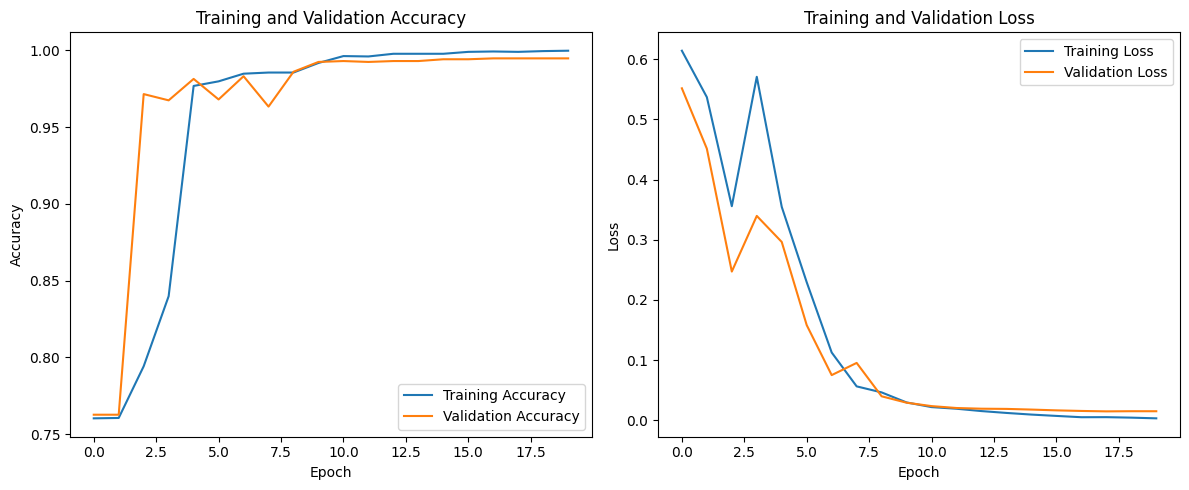

In [55]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test_encoded, y_predict)

# Extract True Negatives, False Positives, False Negatives, True Positives
tn, fp, fn, tp = cf_matrix.ravel()

# Calculate performance metrics
precision = precision_score(y_test_encoded, y_predict)
recall = recall_score(y_test_encoded, y_predict)
f1 = f1_score(y_test_encoded, y_predict)
accuracy = accuracy_score(y_test_encoded, y_predict)

# Print metrics
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%")

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 3. Insights and Considerations
- The **F1 score of 96.68%** reflects strong performance on the training dataset, balancing precision and recall effectively.
- Despite this success, real-world applications require constant monitoring to ensure sustained performance over time. Factors such as data drift or changes in the patterns of spam emails could impact the model's accuracy.
- Enhancing the model with additional features, retraining with updated data, or fine-tuning its parameters can further improve its predictive capabilities.

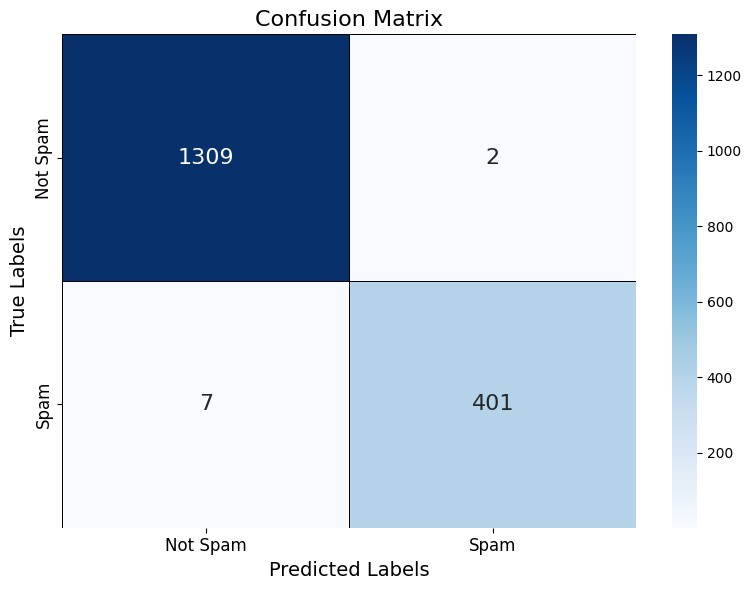

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax, cbar=True,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('True Labels', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16)

ax.xaxis.set_ticklabels(['Not Spam', 'Spam'], fontsize=12)
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'], fontsize=12)

plt.tight_layout()

plt.show()